In [2]:
# Don't change this cell; just run it. 

import numpy as np
from datascience import *

# These lines do some fancy plotting magic.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [3]:
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

def correlation(t, x, y):
    return np.mean(standard_units(t.column(x))*standard_units(t.column(y)))

def slope(table, x, y):
    r = correlation(table, x, y)
    return r * np.std(table.column(y))/np.std(table.column(x))

def intercept(table, x, y):
    a = slope(table, x, y)
    return np.mean(table.column(y)) - a * np.mean(table.column(x))

def fit(table, x, y):
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * table.column(x) + b

def residual(table, x, y):
    return table.column(y) - fit(table, x, y)

def scatter_fit(table, x, y):
    plots.scatter(table.column(x), table.column(y), s=20)
    plots.plot(table.column(x), fit(table, x, y), lw=2, color='gold')
    plots.xlabel(x)
    plots.ylabel(y)

## Creating the Tables

In [60]:
sex_ratio_data = Table.read_table("sex_ratio_data.csv")
sex_ratio_data.show(24)

site,loc,lat,lon,Collector,Collection Year,sex,count,elevation
UC1627627,"Highway 50, Toiyabe National Forest, NV",39.4333,-116.967,D. H. Norris,1992,F,4,2069
UC1627627,"Highway 50, Toiyabe National Forest, NV",39.1042,-119.903,D. H. Norris,1992,M,0,2069
KFCP,"Carrizo Plain National Monument, CA",35.1177,-119.856,K. Fisher,2017,F,6,1077
KFCP,"Carrizo Plain National Monument, CA",35.1177,-119.856,K. Fisher,2017,M,3,1077
UC1731034,"White Pine County, NV",40.0796,-114.079,J. Nachlinger,2002,F,5,1696
UC1731034,"White Pine County, NV",40.0796,-114.079,J. Nachlinger,2002,M,0,1696
KCMNP,"Mojave National Preserve, Cane Spring Area",35.2364,-115.796,K. Fisher,2017,F,34,999
KCMNP,"Mojave National Preserve, Cane Spring Area",35.2364,-115.796,K. Fisher,2017,M,1,999
GMGC,Granite Mountains UC Reserve,34.8077,-115.674,J. Baughman,2016,F,10,1338
GMGC,Granite Mountains UC Reserve,34.8077,-115.674,J. Baughman,2016,M,0,1338


In [5]:
female_elevation = sex_ratio_data.where('sex','F').select('elevation', 'sex', 'count').sort('elevation')
female_elevation

elevation,sex,count
895,F,2
999,F,34
1077,F,6
1274,F,16
1338,F,10
1352,F,18
1361,F,19
1592,F,3
1680,F,4
1680,F,8


In [6]:
male_elevation = sex_ratio_data.where('sex','M').select('elevation', 'sex', 'count').sort('elevation')
male_elevation

elevation,sex,count
895,M,0
999,M,1
1077,M,3
1274,M,2
1338,M,0
1352,M,0
1361,M,0
1592,M,0
1680,M,0
1680,M,2


In [7]:
elevation_count = female_elevation.join('elevation', male_elevation)
elevation_count

elevation,sex,count,sex_2,count_2
895,F,2,M,0
999,F,34,M,1
1077,F,6,M,3
1274,F,16,M,2
1338,F,10,M,0
1352,F,18,M,0
1361,F,19,M,0
1592,F,3,M,0
1680,F,4,M,0
1680,F,4,M,2


## A Few Visualizations

In [61]:
to_graph = Table().with_columns('Elevation',elevation_count.column('elevation'), 
                                'Male Count', elevation_count.column('count_2'),
                                'Female Count', elevation_count.column('count') )
to_graph

Elevation,Male Count,Female Count
895,0,2
999,1,34
1077,3,6
1274,2,16
1338,0,10
1352,0,18
1361,0,19
1592,0,3
1680,0,4
1680,2,4


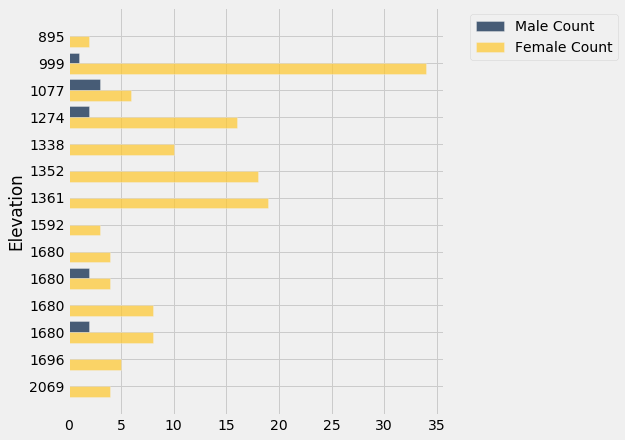

In [62]:
to_graph.barh('Elevation')

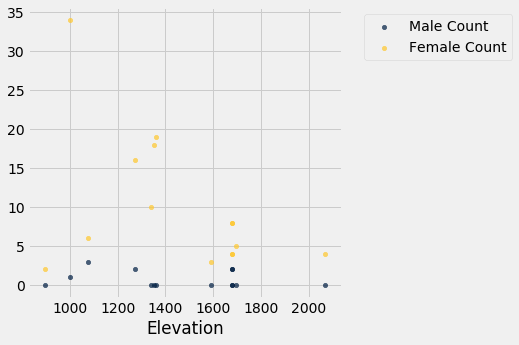

In [10]:
to_graph.scatter("Elevation")

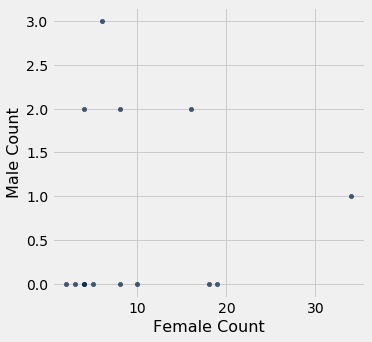

In [11]:
to_graph.scatter('Female Count','Male Count')

(None, -0.012372326213366185)

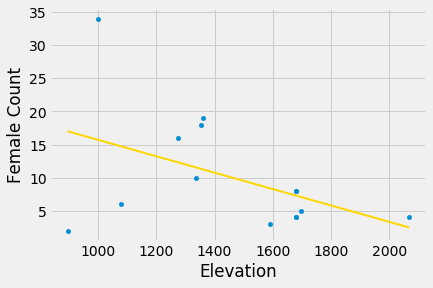

In [12]:
scatter_fit(to_graph, 'Elevation', 'Female Count'), slope(to_graph, 'Elevation', 'Female Count')

(None, -0.0007602026348505881)

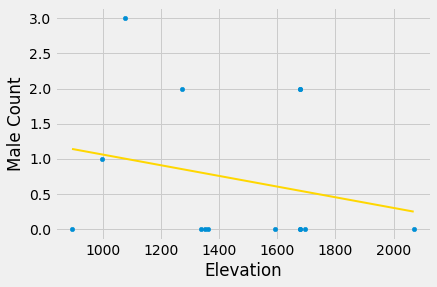

In [13]:
scatter_fit(to_graph, 'Elevation', 'Male Count'), slope(to_graph, 'Elevation', 'Male Count')

## Bootstrapping 

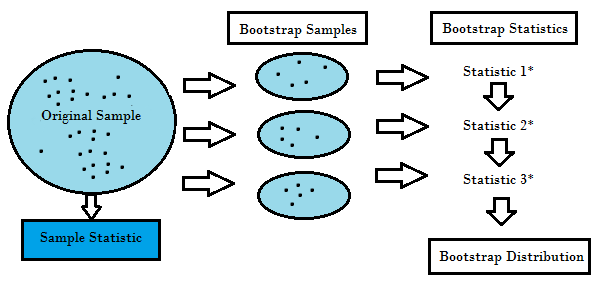

In [14]:
from IPython.display import Image
url = 'https://www.statisticshowto.datasciencecentral.com/wp-content/uploads/2016/10/bootstrap-sample.png'
Image(url,width=600, height=600)

In [15]:
female_elevation.sample(with_replacement=False)

elevation,sex,count
999,F,34
1680,F,8
1077,F,6
1352,F,18
1680,F,4
1592,F,3
1696,F,5
1338,F,10
1361,F,19
895,F,2


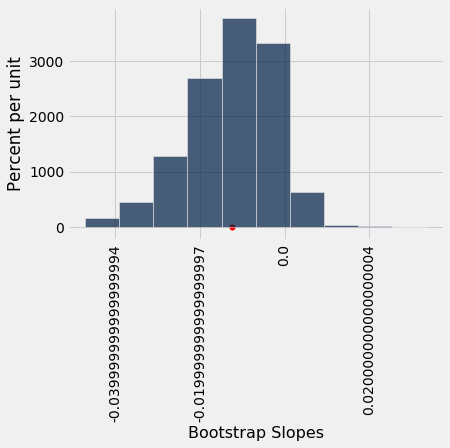

In [16]:
slopes = make_array()
for i in np.arange(5000):
    bootstrap_sample = female_elevation.sample()
    bootstrap_slope = slope(bootstrap_sample, 'elevation', 'count')
    slopes = np.append(slopes, bootstrap_slope)
Table().with_column('Bootstrap Slopes', slopes).hist()
plots.scatter(-0.012372326213366185, 0, color='red', s=30) # Our observed slope

In [17]:
left = percentile(2.5, slopes)
right = percentile(97.5, slopes)
left, right

(-0.03515413146627481, 0.0036362802348558405)

Above is a **95% confidence interval** for slope of line in female sex elevation data. If observed test statistic is outside, we can reject null that any differences between test data and new collected data is due to chance
Male data was impossible to use *efficiently* with so many zeroes.

## Permutation Test

**From Wikipedia:** a permutation test (also called a randomization test, re-randomization test, or an exact test) is a type of statistical significance test in which the distribution of the test statistic under the null hypothesis is obtained by calculating all possible values of the test statistic under rearrangements of the labels on the observed data points. 

In [18]:
female_elevation = female_elevation.drop('sex')
female_elevation

elevation,count
895,2
999,34
1077,6
1274,16
1338,10
1352,18
1361,19
1592,3
1680,4
1680,8


In [19]:
mixed_up_count = female_elevation.sample(with_replacement=False).column('count')
mixed_up_count

array([ 3,  2, 10, 19,  8, 18,  4,  5,  6,  4, 34, 16])

In [20]:
mixed_up_female_elevation = female_elevation.drop('count').with_column('mixed up count',mixed_up_count).drop('sex')
mixed_up_female_elevation

elevation,mixed up count
895,3
999,2
1077,10
1274,19
1338,8
1352,18
1361,4
1592,5
1680,6
1680,4


In [21]:
permutation_graph = female_elevation.join('elevation', mixed_up_female_elevation)
permutation_graph

elevation,count,mixed up count
895,2,3
999,34,2
1077,6,10
1274,16,19
1338,10,8
1352,18,18
1361,19,4
1592,3,5
1680,4,6
1680,4,4


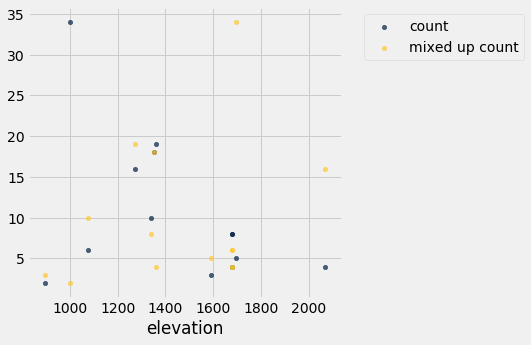

In [22]:
permutation_graph.scatter('elevation')

In [23]:
slope(permutation_graph, 'elevation', 'count'), slope(permutation_graph, 'elevation', 'mixed up count')

(-0.012372326213366185, 0.007353072605842044)

In [72]:
##mixed_up_diffs = make_array()
mixed_up_slopes = make_array()
observed_statistic = slope(permutation_graph, 'elevation', 'count')

for i in np.arange(10000):
    tbl = female_elevation 
    mixing_up_count = tbl.sample(with_replacement=False).column('count')
    mixing_up_female_elevation = tbl.drop('count').with_column('mixed up count',mixing_up_count)
    mixed_up_slope = slope(mixing_up_female_elevation, 'elevation', 'mixed up count')
    mixed_up_slopes = np.append(mixed_up_slopes, mixed_up_slope)
    ##mixed_up_diff = abs(mixed_up_slope - observed_statistic)
    ##mixed_up_diffs = np.append(mixed_up_diffs, mixed_up_diff)
hist_of_slopes= Table().with_column('Simulated Differences', mixed_up_slopes)

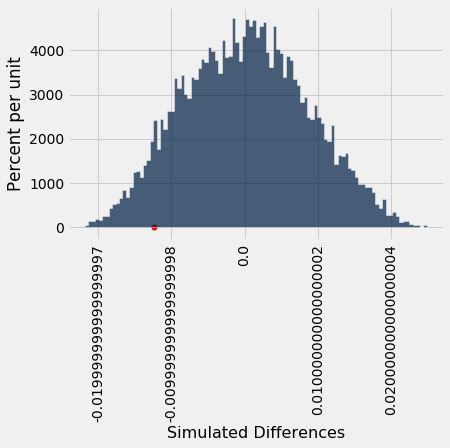

In [73]:
hist_of_slopes.hist(bins=100)
observed_statistic = slope(permutation_graph, 'elevation', 'count')
plots.scatter(observed_statistic, 0, color='red', s=30)

In [74]:
p_value = np.count_nonzero( mixed_up_slopes <= observed_statistic ) / 10000
p_value

0.0692

### If we mix up all the counts of females at each elevation 10,000 times, our observed slope is almost unusual. (This indicates that elevation might play a role in sex determination in mosses.
Definitely need a larger sample size though...

### Proportions

In [50]:
sex_ratio_data = sex_ratio_data.sort('elevation')
sex_ratio_data

site,loc,lat,lon,Collector,Collection Year,sex,count,elevation
CLARK-1250,Sheeps Desert National Wildlife Refuge,36.4353,-115.356,T. Clark,2017,F,2,895
CLARK-1250,Sheeps Desert National Wildlife Refuge,36.4353,-115.356,T. Clark,2017,M,0,895
KCMNP,"Mojave National Preserve, Cane Spring Area",35.2364,-115.796,K. Fisher,2017,F,34,999
KCMNP,"Mojave National Preserve, Cane Spring Area",35.2364,-115.796,K. Fisher,2017,M,1,999
KFCP,"Carrizo Plain National Monument, CA",35.1177,-119.856,K. Fisher,2017,F,6,1077
KFCP,"Carrizo Plain National Monument, CA",35.1177,-119.856,K. Fisher,2017,M,3,1077
KFIJ,"Red Rock, NV",36.0716,-115.468,Israel Jimenez,2016,F,16,1274
KFIJ,"Red Rock, NV",36.0716,-115.468,Israel Jimenez,2016,M,2,1274
GMGC,Granite Mountains UC Reserve,34.8077,-115.674,J. Baughman,2016,F,10,1338
GMGC,Granite Mountains UC Reserve,34.8077,-115.674,J. Baughman,2016,M,0,1338


In [28]:
female_count = sex_ratio_data.where('sex', 'F').column('count')
len(female_count)

12

In [29]:
male_count = sex_ratio_data.where('sex', 'M').column('count')
len(male_count)

12

In [30]:
proportions = [f/(m+f) for f,m in zip(list(female_count), list(male_count))]
len(proportions)

12

In [51]:
dirty_elevations = sex_ratio_data.column('elevation')
elevation_data = make_array()
for elem in dirty_elevations:
    if elem not in elevation_data:
        elevation_data = np.append(elevation_data, elem)
elevation_datum_1680 = np.append(elevation_data, 1680)
elevation_data = Table().with_column('0',elevation_datum_1680).sort(0).column(0)
elevation_data

array([ 895.,  999., 1077., 1274., 1338., 1352., 1361., 1592., 1680.,
       1680., 1696., 2069.])

In [52]:
sex_ratios = Table().with_column('Elevation', elevation_data, 'Female Count', female_count, 'Male Count', male_count, 'Female Proportions', proportions)
sex_ratios

Elevation,Female Count,Male Count,Female Proportions
895,2,0,1
999,34,1,0.971429
1077,6,3,0.666667
1274,16,2,0.888889
1338,10,0,1
1352,18,0,1
1361,19,0,1
1592,3,0,1
1680,4,0,1
1680,8,2,0.8


In [53]:
male_proportions = [1-elem for elem in proportions]
male_proportions

[0.0,
 0.02857142857142858,
 0.33333333333333337,
 0.11111111111111116,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.19999999999999996,
 0.0,
 0.0]

In [54]:
sex_ratios = sex_ratios.with_column('Male Proportions', male_proportions)
sex_ratios.show(12)

Elevation,Female Count,Male Count,Female Proportions,Male Proportions
895,2,0,1,0
999,34,1,0.971429,0.0285714
1077,6,3,0.666667,0.333333
1274,16,2,0.888889,0.111111
1338,10,0,1,0
1352,18,0,1,0
1361,19,0,1,0
1592,3,0,1,0
1680,4,0,1,0
1680,8,2,0.8,0.2


In [55]:
model_propotions = [np.average(sex_ratios.column('Female Proportions')), np.average(sex_ratios.column('Male Proportions'))]
model_propotions

[0.9439153439153439, 0.05608465608465609]

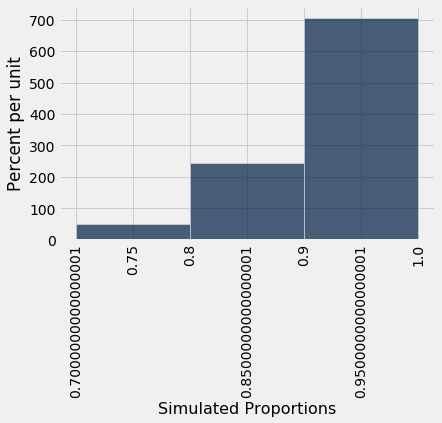

In [59]:
simulated_proportions = make_array()
sample_size = sex_ratios.num_rows #really small sample size so not great conclusions - can make this higher to make it better
repetitions = 10000

for i in np.arange(repetitions):
    simulated_proportion = sample_proportions(sample_size, model_propotions).item(0)
    simulated_proportions = np.append(simulated_proportions, simulated_proportion)

Table().with_column('Simulated Proportions', simulated_proportions).hist(bins=np.arange(0.7,1.0,0.1))